In [1]:
from mlwpy import *
import pymc3 as pm

# 너무 많은 내용을 출력하지 않도록 설정합니다.
import logging
pymc3_log = logging.getLogger('pymc3')
pymc3_log.setLevel(2**20)

In [2]:
# 새로운 노트북이므로, 이전에 작업하던 데이터를 다시 만들어줍니다.
linreg_ftrs_p1 = np.c_[np.arange(10), np.ones(10)] # +1 트릭

true_wgts  = m,b = w_1, w_0 = 3,2
linreg_tgt = rdot(true_wgts, linreg_ftrs_p1)

linreg_table = pd.DataFrame(linreg_ftrs_p1, 
                            columns=['ftr_1', 'ones'])
linreg_table['tgt'] = linreg_tgt
linreg_table[:3]

,ftr_1,ones,tgt
0,0.0000,1.0000,2.0000
1,1.0000,1.0000,5.0000
2,2.0000,1.0000,8.0000


In [3]:
logreg_ftr = np.random.uniform(5,15, size=(100,))

true_wgts  = m,b = -2, 20
line_of_logodds = m*logreg_ftr + b
prob_at_x = np.exp(line_of_logodds) / (1 + np.exp(line_of_logodds))

logreg_tgt = np.random.binomial(1, prob_at_x, len(logreg_ftr))

logreg_ftrs_p1 = np.c_[logreg_ftr,
                       np.ones_like(logreg_ftr)]

logreg_table = pd.DataFrame(logreg_ftrs_p1, 
                            columns=['ftr_1','ones'])
logreg_table['tgt'] = logreg_tgt
display(logreg_table.head())

,ftr_1,ones,tgt
0,8.7454,1.0000,1
1,14.5071,1.0000,0
2,12.3199,1.0000,0
3,10.9866,1.0000,0
4,6.5602,1.0000,1


In [4]:
with pm.Model() as model:
    # 우리가 아직 모르는 것들을 추측하기 위해
    # 분포를 설정하는 템플릿입니다.
    sd      = pm.HalfNormal('sd', sd=1)
    intercept  = pm.Normal('Intercept', 0, sd=20)
    ftr_1_wgt  = pm.Normal('ftr_1_wgt', 0, sd=20)

    # 초기 추측과 입력 데이터를 통해 결과를 출력합니다.
    # 이는 y = m x + b의 형태입니다.
    preds = ftr_1_wgt * linreg_table['ftr_1'] + intercept 

    # 추측과 입력 데이터, 실제 출력간의 관계
    # target = preds + noise(sd)  (noise == 오차 허용 범위)
    target = pm.Normal('tgt', 
                       mu=preds, sd=sd, 
                       observed=linreg_table['tgt'])

    linreg_trace = pm.sample(1000, progressbar=False)

In [5]:
pm.summary(linreg_trace)[['mean']]

,mean
Intercept,2.0000
ftr_1_wgt,3.0000
sd,0.0000


In [6]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('tgt ~ ftr_1', linreg_table,
                           family=pm.glm.families.Normal())
    linreg_trace = pm.sample(5000, progressbar=False)
pm.summary(linreg_trace)[['mean']]

,mean
Intercept,2.0000
ftr_1,3.0000
sd,0.0000


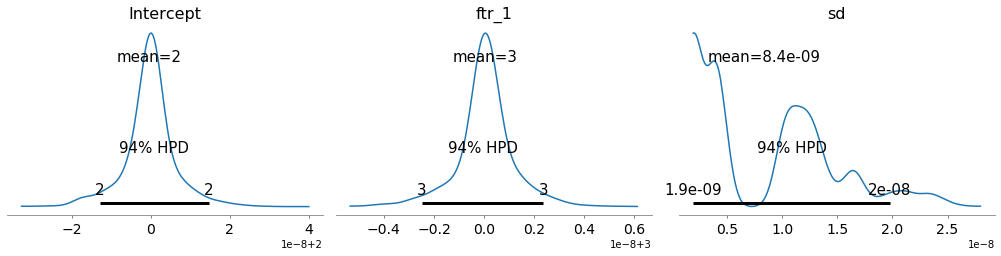

<Figure size 288x216 with 0 Axes>

In [7]:
pm.plots.plot_posterior(linreg_trace)
plt.show()

In [8]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('tgt ~ ftr_1', logreg_table, 
                            family=pm.glm.families.Binomial())
    logreg_trace = pm.sample(10000, progressbar=False)
pm.summary(logreg_trace)[['mean']]

,mean
Intercept,22.6680
ftr_1,-2.2550


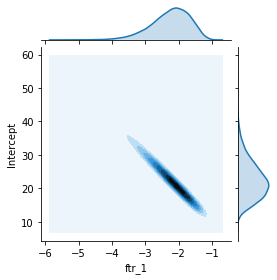

In [9]:
%matplotlib inline

df_trace = pm.trace_to_dataframe(logreg_trace)
sns.jointplot('ftr_1', 'Intercept', data=df_trace, 
              kind='kde', stat_func=None, height=4);